# Data Preprocessing

This notebook clarifies the nature of our data and the series of preprocessing steps implemented. We've adopted the Medallion Architecture as our guiding principle for data refinement. Within this structure, every data source progresses through three distinct layers: Bronze, Silver, and Gold. Each layer serves its own unique purpose in the pipeline.

## Overview of the Layers:

### 1. **Bronze Layer (Raw Data)**
- **Nature**: This is the landing area for our raw data, ingested directly from the source without any alterations.
- **Purpose**: To store an immutable, 1:1 replica of the source data. It serves as the foundational bedrock upon which further layers are built.

### 2. **Silver Layer (Cleaned Data)**
- **Nature**: Data in this layer has been cleaned, enriched, and is stored in a format suitable for analysis. Any inconsistencies, missing values, or anomalies from the Bronze layer have been addressed here.
- **Purpose**: To have a reliable, single version of the truth which is suitable for analysis but without any specific business logic applied. This is the primary layer for data scientists and analysts to query against.

### 3. **Gold Layer (Business-Ready Data)**
- **Nature**: This layer houses data that has been aggregated, enriched, and optimized for specific business use-cases. It is derived from the Silver layer.
- **Purpose**: To provide business-ready datasets for driving insights, reports, visualizations, and machine learning models. This layer is tailored to end-users and specific analytical objectives.


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
from scipy.stats import normaltest


### Player skill dataset

In [23]:
# Bronze Layer
FUT_player_data = pd.read_csv('../data/FUT_player_data.csv')
pd.set_option('display.max_columns', None)
FUT_player_data.head()

,id,futbin_id,name,height,weight,age,club,league,nation,rarity,position,foot,attackWorkRate,defenseWorkRate,cardColor,overallRating,pace,shooting,passing,dribbling,defending,physicality,pace_acceleration,pace_sprintSpeed,shooting_positioning,shooting_finishing,shooting_shotPower,shooting_longShots,shooting_volleys,shooting_penalties,passing_vision,passing_crossing,passing_freeKickAccuracy,passing_shortPassing,passing_longPassing,passing_curve,dribbling_agility,dribbling_balance,dribbling_reactions,dribbling_ballControl,dribbling_dribbling,dribbling_composure,defending_interceptions,defending_headingAccuracy,defending_standingTackle,defending_slidingTackle,defending_defenseAwareness,phsyicality_jumping,physicality_stamina,physicality_strength,physicality_aggression,goalkeeper_diving,goalkeeper_handling,goalkeeper_kicking,goalkeeper_positioning,goalkeeper_reflexes,goalkeeper_speed
0,18949,54231,Kylian Mbappé,182,73,24,73,16,18,16,ST,Right,High,Low,gold,99,99,98,92,99,45,87,99.0,99.0,99.0,99.0,99.0,94.0,95.0,93.0,95.0,90.0,80.0,97.0,82.0,92.0,99.0,91.0,99.0,99.0,99.0,99.0,48.0,87.0,43.0,40.0,33.0,88.0,99.0,87.0,73.0,NaN,NaN,NaN,NaN,NaN,99
1,18981,54251,Karim Benzema,185,81,35,607,350,18,164,CF,Right,High,Med,gold,99,97,99,93,98,50,97,97.0,97.0,99.0,99.0,99.0,97.0,99.0,97.0,99.0,84.0,83.0,98.0,86.0,93.0,91.0,90.0,99.0,99.0,99.0,99.0,55.0,99.0,33.0,25.0,56.0,99.0,99.0,99.0,90.0,NaN,NaN,NaN,NaN,NaN,97
2,18982,54249,Zinedine Zidane,185,77,51,112658,2118,18,171,CAM,Right,Med,Med,gold,99,92,96,99,97,87,90,93.0,92.0,96.0,95.0,95.0,99.0,97.0,94.0,99.0,99.0,99.0,99.0,99.0,99.0,88.0,90.0,99.0,99.0,99.0,99.0,95.0,99.0,88.0,72.0,83.0,87.0,94.0,92.0,83.0,NaN,NaN,NaN,NaN,NaN,92
3,18730,54005,Pelé,173,70,82,112658,2118,54,153,LW,Right,High,Med,gold,99,96,97,94,99,61,78,96.0,96.0,98.0,99.0,95.0,95.0,96.0,94.0,98.0,91.0,90.0,97.0,89.0,90.0,97.0,96.0,99.0,99.0,99.0,99.0,68.0,96.0,54.0,50.0,56.0,90.0,91.0,78.0,61.0,NaN,NaN,NaN,NaN,NaN,96
4,19001,54277,Robert Lewandowski,185,81,35,241,53,37,164,ST,Right,High,Med,gold,99,97,99,92,97,53,99,98.0,97.0,99.0,99.0,99.0,99.0,99.0,99.0,94.0,83.0,99.0,98.0,82.0,92.0,87.0,92.0,99.0,99.0,97.0,99.0,60.0,99.0,52.0,24.0,42.0,99.0,97.0,99.0,99.0,NaN,NaN,NaN,NaN,NaN,97


In [24]:
# Load data
club_ids = pd.read_csv('../data/club_ids.csv', index_col='id')
league_ids = pd.read_csv('../data/league_ids.csv', index_col='id')
nation_ids = pd.read_csv('../data/nation_ids.csv', index_col='id')

# Convert DataFrames to dictionaries using the correct column name
club_ids_dict = club_ids['ClubName'].to_dict()
league_ids_dict = league_ids['LeagueName'].to_dict()
nation_ids_dict = nation_ids['NationName'].to_dict()

# Use map for vectorized replacement
FUT_player_data['club_name'] = FUT_player_data['club'].map(club_ids_dict)
FUT_player_data['league_name'] = FUT_player_data['league'].map(league_ids_dict)
FUT_player_data['nation_name'] = FUT_player_data['nation'].map(nation_ids_dict)

#unified bronze df from raw dfs
bronze_player_ratings = FUT_player_data.copy()



In [34]:
# Define the mapping dictionary
position_mapping = {
    'ST': 'Forward', 'CF': 'Forward', 'LW': 'Forward', 'RW': 'Forward',
    'CAM': 'Midfielder', 'CM': 'Midfielder', 'CDM': 'Midfielder', 'LM': 'Midfielder', 'RM': 'Midfielder',
    'CB': 'Defender', 'LB': 'Defender', 'RB': 'Defender', 'LWB': 'Defender', 'RWB': 'Defender',
    'GK': 'Goalkeeper'
}

# Assuming df is your DataFrame and 'position' is the column containing the positions
bronze_player_ratings['position_group'] = bronze_player_ratings['position'].map(position_mapping)


bronze_player_ratings.head()
# get unique position values
# bronze_player_ratings['position'].unique()

,id,futbin_id,name,height,weight,age,club,league,nation,rarity,position,foot,attackWorkRate,defenseWorkRate,cardColor,overallRating,pace,shooting,passing,dribbling,defending,physicality,pace_acceleration,pace_sprintSpeed,shooting_positioning,shooting_finishing,shooting_shotPower,shooting_longShots,shooting_volleys,shooting_penalties,passing_vision,passing_crossing,passing_freeKickAccuracy,passing_shortPassing,passing_longPassing,passing_curve,dribbling_agility,dribbling_balance,dribbling_reactions,dribbling_ballControl,dribbling_dribbling,dribbling_composure,defending_interceptions,defending_headingAccuracy,defending_standingTackle,defending_slidingTackle,defending_defenseAwareness,phsyicality_jumping,physicality_stamina,physicality_strength,physicality_aggression,goalkeeper_diving,goalkeeper_handling,goalkeeper_kicking,goalkeeper_positioning,goalkeeper_reflexes,goalkeeper_speed,club_name,league_name,nation_name,position_group
0,18949,54231,Kylian Mbappé,182,73,24,73,16,18,16,ST,Right,High,Low,gold,99,99,98,92,99,45,87,99.0,99.0,99.0,99.0,99.0,94.0,95.0,93.0,95.0,90.0,80.0,97.0,82.0,92.0,99.0,91.0,99.0,99.0,99.0,99.0,48.0,87.0,43.0,40.0,33.0,88.0,99.0,87.0,73.0,NaN,NaN,NaN,NaN,NaN,99,Paris SG,Ligue 1,France,Forward
1,18981,54251,Karim Benzema,185,81,35,607,350,18,164,CF,Right,High,Med,gold,99,97,99,93,98,50,97,97.0,97.0,99.0,99.0,99.0,97.0,99.0,97.0,99.0,84.0,83.0,98.0,86.0,93.0,91.0,90.0,99.0,99.0,99.0,99.0,55.0,99.0,33.0,25.0,56.0,99.0,99.0,99.0,90.0,NaN,NaN,NaN,NaN,NaN,97,Al Ittihad,MBS Pro League (SAU 1),France,Forward
2,18982,54249,Zinedine Zidane,185,77,51,112658,2118,18,171,CAM,Right,Med,Med,gold,99,92,96,99,97,87,90,93.0,92.0,96.0,95.0,95.0,99.0,97.0,94.0,99.0,99.0,99.0,99.0,99.0,99.0,88.0,90.0,99.0,99.0,99.0,99.0,95.0,99.0,88.0,72.0,83.0,87.0,94.0,92.0,83.0,NaN,NaN,NaN,NaN,NaN,92,FUT ICONS,Icons,France,Midfielder
3,18730,54005,Pelé,173,70,82,112658,2118,54,153,LW,Right,High,Med,gold,99,96,97,94,99,61,78,96.0,96.0,98.0,99.0,95.0,95.0,96.0,94.0,98.0,91.0,90.0,97.0,89.0,90.0,97.0,96.0,99.0,99.0,99.0,99.0,68.0,96.0,54.0,50.0,56.0,90.0,91.0,78.0,61.0,NaN,NaN,NaN,NaN,NaN,96,FUT ICONS,Icons,Brazil,Forward
4,19001,54277,Robert Lewandowski,185,81,35,241,53,37,164,ST,Right,High,Med,gold,99,97,99,92,97,53,99,98.0,97.0,99.0,99.0,99.0,99.0,99.0,99.0,94.0,83.0,99.0,98.0,82.0,92.0,87.0,92.0,99.0,99.0,97.0,99.0,60.0,99.0,52.0,24.0,42.0,99.0,97.0,99.0,99.0,NaN,NaN,NaN,NaN,NaN,97,FC Barcelona,LaLiga Santander,Poland,Forward


In [6]:
# Gold Layer

# List of numerical columns
numerical_cols = [
    'height', 'weight', 'age', 'overallRating', 'pace', 'shooting',
    'passing', 'dribbling', 'defending', 'physicality',
    'pace_acceleration', 'pace_sprintSpeed', 'shooting_positioning',
    'shooting_finishing', 'shooting_shotPower', 'shooting_longShots',
    'shooting_volleys', 'shooting_penalties', 'passing_vision',
    'passing_crossing', 'passing_freeKickAccuracy', 'passing_shortPassing',
    'passing_longPassing', 'passing_curve', 'dribbling_agility',
    'dribbling_balance', 'dribbling_reactions', 'dribbling_ballControl',
    'dribbling_dribbling', 'dribbling_composure', 'defending_interceptions',
    'defending_headingAccuracy', 'defending_standingTackle',
    'defending_slidingTackle', 'defending_defenseAwareness',
    'phsyicality_jumping', 'physicality_stamina', 'physicality_strength',
    'physicality_aggression', 'goalkeeper_diving', 'goalkeeper_handling',
    'goalkeeper_kicking', 'goalkeeper_positioning', 'goalkeeper_reflexes',
    'goalkeeper_speed'
]

# List of categorical columns
categorical_cols = [
     'position', 'foot',
    'attackWorkRate', 'defenseWorkRate', 'cardColor'
]
player_ratings_scaled = player_ratings.copy()

# Handle missing values for numerical columns with mean of that column
for col in numerical_cols:
    player_ratings_scaled[col].fillna(player_ratings_scaled[col].mean(), inplace=True)

# Handle missing values for categorical columns with mode (most frequent value) of that column
for col in categorical_cols:
    player_ratings_scaled[col].fillna(player_ratings_scaled[col].mode()[0], inplace=True)

# Standardize numerical columns
scaler = StandardScaler()
player_ratings_scaled[numerical_cols] = scaler.fit_transform(player_ratings_scaled[numerical_cols])

# One-hot encode categorical columns
player_ratings_scaled = pd.get_dummies(player_ratings_scaled, columns=categorical_cols)
player_ratings_scaled

NameError: name 'player_ratings' is not defined

### Transfer Fees

In [31]:
# Bronze Layer

top_5_leagues = [
    'combined_premier-league.csv', 
    'combined_serie-a.csv', 
    'combined_laliga.csv', 
    'combined_1-bundesliga.csv', 
    'combined_ligue-1.csv'
    ]

dfs  = []
for league in top_5_leagues:
    dfs.append(pd.read_csv(f'../data/{league}'))

bronze_transfer_fees = pd.concat(dfs, ignore_index=True)
print(bronze_transfer_fees.columns)
bronze_transfer_fees

Index(['club', 'name', 'age', 'nationality', 'position', 'short_pos',
       'market_value', 'dealing_club', 'dealing_country', 'fee', 'movement',
       'window', 'league', 'season', 'is_loan', 'loan_status', 'Year'],
      dtype='object')


,club,name,age,nationality,position,short_pos,market_value,dealing_club,dealing_country,fee,movement,window,league,season,is_loan,loan_status,Year
0,Arsenal FC,John Jensen,27.0,Denmark,Central Midfield,CM,NaN,Bröndby IF,Denmark,1600000.0,in,summer,Premier League,1992,False,NaN,1992
1,Arsenal FC,David Rocastle,25.0,England,Attacking Midfield,AM,NaN,Leeds,England,2400000.0,out,summer,Premier League,1992,False,NaN,1992
2,Arsenal FC,Perry Groves,27.0,England,Left Winger,LW,NaN,Southampton,England,850000.0,out,summer,Premier League,1992,False,NaN,1992
3,Arsenal FC,Gary McKeown,21.0,England,midfield,midfield,NaN,Dundee FC,Scotland,NaN,out,summer,Premier League,1992,False,NaN,1992
4,Arsenal FC,Ty Gooden,19.0,England,midfield,midfield,NaN,Wycombe,England,NaN,out,summer,Premier League,1992,False,NaN,1992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77091,Stade Rennais FC,Jérémy Gélin,23.0,France,Centre-Back,CB,4800000.0,Royal Antwerp,Belgium,0.0,out,summer,Ligue 1,2020,True,free loan,2020
77092,Stade Rennais FC,Riffi Mandanda,27.0,DR Congo,Goalkeeper,GK,325000.0,Without Club,NaN,NaN,out,summer,Ligue 1,2020,False,NaN,2020
77093,Stade Rennais FC,Joris Gnagnon,23.0,France,Centre-Back,CB,4800000.0,Sevilla FC,Spain,0.0,out,summer,Ligue 1,2020,True,end of loan,2020
77094,Stade Rennais FC,M'Baye Niang,26.0,Senegal,Centre-Forward,CF,10000000.0,Ahli,Saudi Arabia,1500000.0,out,winter,Ligue 1,2020,True,loan with fee,2020


In [32]:
bronze_transfer_fees.head()

,club,name,age,nationality,position,short_pos,market_value,dealing_club,dealing_country,fee,movement,window,league,season,is_loan,loan_status,Year
0,Arsenal FC,John Jensen,27.0,Denmark,Central Midfield,CM,NaN,Bröndby IF,Denmark,1600000.0,in,summer,Premier League,1992,False,NaN,1992
1,Arsenal FC,David Rocastle,25.0,England,Attacking Midfield,AM,NaN,Leeds,England,2400000.0,out,summer,Premier League,1992,False,NaN,1992
2,Arsenal FC,Perry Groves,27.0,England,Left Winger,LW,NaN,Southampton,England,850000.0,out,summer,Premier League,1992,False,NaN,1992
3,Arsenal FC,Gary McKeown,21.0,England,midfield,midfield,NaN,Dundee FC,Scotland,NaN,out,summer,Premier League,1992,False,NaN,1992
4,Arsenal FC,Ty Gooden,19.0,England,midfield,midfield,NaN,Wycombe,England,NaN,out,summer,Premier League,1992,False,NaN,1992


In [6]:
# Silver Layer
preprocessed_transfer_fees = bronze_transfer_fees.copy()

# Fill NaN values
preprocessed_transfer_fees['market_value'].fillna(0, inplace=True)
preprocessed_transfer_fees['dealing_club'].fillna("Unknown", inplace=True)
preprocessed_transfer_fees['dealing_country'].fillna("Unknown", inplace=True)
preprocessed_transfer_fees['fee'].fillna(0, inplace=True)
preprocessed_transfer_fees['movement'].fillna("Unknown", inplace=True)
preprocessed_transfer_fees['window'].fillna("Unknown", inplace=True)
preprocessed_transfer_fees['loan_status'].fillna("Not Applicable", inplace=True)

# Standardize String Values
preprocessed_transfer_fees['club'] = preprocessed_transfer_fees['club'].str.title()
preprocessed_transfer_fees['name'] = preprocessed_transfer_fees['name'].str.title()
preprocessed_transfer_fees['position'] = preprocessed_transfer_fees['position'].str.title()
preprocessed_transfer_fees['short_pos'] = preprocessed_transfer_fees['short_pos'].str.upper()
preprocessed_transfer_fees['nationality'] = preprocessed_transfer_fees['nationality'].str.title()
preprocessed_transfer_fees['dealing_club'] = preprocessed_transfer_fees['dealing_club'].str.title()
preprocessed_transfer_fees['dealing_country'] = preprocessed_transfer_fees['dealing_country'].str.title()
preprocessed_transfer_fees['league'] = preprocessed_transfer_fees['league'].str.title()

# Feature Engineering: Derive Age Group
preprocessed_transfer_fees['age_group'] = pd.cut(preprocessed_transfer_fees['age'], bins=[0, 20, 25, 30, 100], labels=['<20', '20-25', '25-30', '30+'])

preprocessed_transfer_fees

,club,name,age,nationality,position,short_pos,market_value,dealing_club,dealing_country,fee,movement,window,league,season,is_loan,loan_status,Year,age_group
0,Arsenal Fc,John Jensen,27.0,Denmark,Central Midfield,CM,0.0,Bröndby If,Denmark,1600000.0,in,summer,Premier League,1992,False,Not Applicable,1992,25-30
1,Arsenal Fc,David Rocastle,25.0,England,Attacking Midfield,AM,0.0,Leeds,England,2400000.0,out,summer,Premier League,1992,False,Not Applicable,1992,20-25
2,Arsenal Fc,Perry Groves,27.0,England,Left Winger,LW,0.0,Southampton,England,850000.0,out,summer,Premier League,1992,False,Not Applicable,1992,25-30
3,Arsenal Fc,Gary Mckeown,21.0,England,Midfield,MIDFIELD,0.0,Dundee Fc,Scotland,0.0,out,summer,Premier League,1992,False,Not Applicable,1992,20-25
4,Arsenal Fc,Ty Gooden,19.0,England,Midfield,MIDFIELD,0.0,Wycombe,England,0.0,out,summer,Premier League,1992,False,Not Applicable,1992,<20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77091,Stade Rennais Fc,Jérémy Gélin,23.0,France,Centre-Back,CB,4800000.0,Royal Antwerp,Belgium,0.0,out,summer,Ligue 1,2020,True,free loan,2020,20-25
77092,Stade Rennais Fc,Riffi Mandanda,27.0,Dr Congo,Goalkeeper,GK,325000.0,Without Club,Unknown,0.0,out,summer,Ligue 1,2020,False,Not Applicable,2020,25-30
77093,Stade Rennais Fc,Joris Gnagnon,23.0,France,Centre-Back,CB,4800000.0,Sevilla Fc,Spain,0.0,out,summer,Ligue 1,2020,True,end of loan,2020,20-25
77094,Stade Rennais Fc,M'Baye Niang,26.0,Senegal,Centre-Forward,CF,10000000.0,Ahli,Saudi Arabia,1500000.0,out,winter,Ligue 1,2020,True,loan with fee,2020,25-30


# Check data

In [7]:
# write to csv
preprocessed_transfer_fees.to_csv('../data/preprocessed_transfer_fees.csv', index=False)

### Duplicate names

In [14]:
# Analysis
# raw_player_ratings
# Identify duplicate names
duplicate_names = raw_player_ratings[raw_player_ratings.duplicated(subset=['name'], keep=False)]

# Sort the DataFrame by name to better visualize the duplicates
duplicate_names = duplicate_names.sort_values(by='name')

# Display the first few rows of duplicate names
# duplicate_names.shape, raw_player_ratings.shape
duplicate_names.head()


,id,futbin_id,name,height,weight,age,club,league,nation,rarity,position,foot,attackWorkRate,defenseWorkRate,cardColor,overallRating,pace,shooting,passing,dribbling,defending,physicality,pace_acceleration,pace_sprintSpeed,shooting_positioning,shooting_finishing,shooting_shotPower,shooting_longShots,shooting_volleys,shooting_penalties,passing_vision,passing_crossing,passing_freeKickAccuracy,passing_shortPassing,passing_longPassing,passing_curve,dribbling_agility,dribbling_balance,dribbling_reactions,dribbling_ballControl,dribbling_dribbling,dribbling_composure,defending_interceptions,defending_headingAccuracy,defending_standingTackle,defending_slidingTackle,defending_defenseAwareness,phsyicality_jumping,physicality_stamina,physicality_strength,physicality_aggression,goalkeeper_diving,goalkeeper_handling,goalkeeper_kicking,goalkeeper_positioning,goalkeeper_reflexes,goalkeeper_speed
5025,18492,53641,Aaron Molinas,175,67,23,111715,353,52,52,CAM,Right,Med,Med,silver,73,72,57,73,76,51,59,79.0,67.0,70.0,56.0,60.0,60.0,44.0,44.0,80.0,69.0,60.0,75.0,76.0,57.0,85.0,73.0,71.0,76.0,75.0,74.0,54.0,39.0,52.0,44.0,55.0,55.0,75.0,52.0,59.0,NaN,NaN,NaN,NaN,NaN,73
5240,7693,36491,Aaron Molinas,175,67,23,1877,1003,52,53,CAM,Right,Med,Med,silver,73,72,57,73,76,51,59,79.0,67.0,70.0,56.0,60.0,60.0,44.0,44.0,80.0,69.0,60.0,75.0,76.0,57.0,85.0,73.0,71.0,76.0,75.0,74.0,54.0,39.0,52.0,44.0,55.0,55.0,75.0,52.0,59.0,NaN,NaN,NaN,NaN,NaN,73
4007,1380,28808,Aaron Mooy,175,68,33,78,50,195,0,CM,Right,Med,Med,gold,76,62,72,78,74,69,75,67.0,57.0,70.0,68.0,76.0,78.0,66.0,73.0,79.0,77.0,72.0,80.0,80.0,73.0,68.0,77.0,72.0,77.0,73.0,80.0,70.0,50.0,72.0,69.0,72.0,72.0,78.0,74.0,75.0,NaN,NaN,NaN,NaN,NaN,62
2435,17111,50487,Aaron Mooy,175,68,33,78,50,195,3,CM,Right,Med,Med,gold,83,73,80,85,81,76,82,79.0,68.0,78.0,76.0,84.0,87.0,73.0,81.0,86.0,84.0,78.0,87.0,87.0,80.0,74.0,84.0,79.0,84.0,80.0,88.0,77.0,55.0,79.0,76.0,79.0,79.0,85.0,81.0,82.0,NaN,NaN,NaN,NaN,NaN,73
2641,6,26328,Aaron Ramsdale,191,77,25,1,13,14,1,GK,Right,Med,Med,gold,82,48,25,36,47,18,48,47.0,50.0,18.0,14.0,64.0,15.0,16.0,25.0,64.0,15.0,16.0,54.0,54.0,17.0,53.0,49.0,80.0,35.0,18.0,65.0,24.0,15.0,16.0,15.0,20.0,66.0,35.0,59.0,35.0,83.0,77.0,85.0,78.0,84.0,48


# NEED TO FIND WHICH PLAYER TO JOIN WHEN THERE ARE DUPLICATES

## Evaluate data quality


In [17]:
# Define a list of numerical columns that should have only positive values
positive_value_columns = ['height', 'weight', 'age', 'overallRating', 'pace', 
                          'shooting', 'passing', 'dribbling', 'defending', 'physicality']

# Check for any non-positive values in these columns
non_positive_values = raw_player_ratings[positive_value_columns].apply(lambda x: x <= 0)

# Display the rows with non-positive values
invalid_rows = raw_player_ratings[non_positive_values.any(axis=1)]
invalid_rows

,id,futbin_id,name,height,weight,age,club,league,nation,rarity,position,foot,attackWorkRate,defenseWorkRate,cardColor,overallRating,pace,shooting,passing,dribbling,defending,physicality,pace_acceleration,pace_sprintSpeed,shooting_positioning,shooting_finishing,shooting_shotPower,shooting_longShots,shooting_volleys,shooting_penalties,passing_vision,passing_crossing,passing_freeKickAccuracy,passing_shortPassing,passing_longPassing,passing_curve,dribbling_agility,dribbling_balance,dribbling_reactions,dribbling_ballControl,dribbling_dribbling,dribbling_composure,defending_interceptions,defending_headingAccuracy,defending_standingTackle,defending_slidingTackle,defending_defenseAwareness,phsyicality_jumping,physicality_stamina,physicality_strength,physicality_aggression,goalkeeper_diving,goalkeeper_handling,goalkeeper_kicking,goalkeeper_positioning,goalkeeper_reflexes,goalkeeper_speed
6,19004,54274,Gianluigi Donnarumma,196,90,24,73,16,27,164,GK,Right,Med,High,gold,99,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.0,95.0,92.0,98.0,99.0,77
21,18973,54259,Alisson,191,91,30,9,13,54,16,GK,Right,Med,Med,gold,98,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.0,96.0,94.0,98.0,99.0,66
31,17227,50602,Lionel Messi,169,67,36,73,16,52,5,RW,Left,High,Low,gold,98,0,0,0,0,0,0,97.0,90.0,99.0,99.0,96.0,99.0,98.0,92.0,99.0,91.0,99.0,99.0,97.0,99.0,96.0,99.0,97.0,99.0,99.0,99.0,47.0,82.0,41.0,28.0,24.0,82.0,87.0,82.0,53.0,NaN,NaN,NaN,NaN,NaN,93
49,19010,54295,Iker Casillas,185,0,42,112658,2118,45,171,GK,Left,Med,High,gold,97,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.0,95.0,91.0,96.0,99.0,74
61,18948,54232,Jan Oblak,188,87,30,240,53,44,16,GK,Right,Med,Med,gold,97,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.0,98.0,88.0,96.0,97.0,57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19030,14789,47568,Jiahui Zhang,182,0,20,112978,2012,155,0,CM,Right,Med,Med,bronze,46,54,37,46,46,43,51,48.0,58.0,52.0,30.0,51.0,33.0,36.0,42.0,44.0,38.0,35.0,53.0,50.0,33.0,61.0,62.0,41.0,45.0,42.0,43.0,40.0,49.0,45.0,46.0,40.0,51.0,43.0,54.0,51.0,NaN,NaN,NaN,NaN,NaN,53
19031,14790,47577,Ziye Zhao,180,0,19,112978,2012,155,0,RW,Right,Med,Med,bronze,46,63,48,40,47,24,44,67.0,60.0,40.0,49.0,64.0,31.0,43.0,54.0,42.0,48.0,35.0,38.0,33.0,39.0,54.0,66.0,39.0,45.0,47.0,40.0,21.0,36.0,21.0,25.0,23.0,41.0,42.0,52.0,26.0,NaN,NaN,NaN,NaN,NaN,63
19032,15077,47296,Antonio D'Silva,182,0,23,113257,2149,159,0,GK,Right,Med,Med,bronze,46,19,13,17,28,11,32,17.0,21.0,6.0,8.0,35.0,10.0,10.0,14.0,23.0,14.0,13.0,21.0,21.0,14.0,36.0,48.0,35.0,14.0,8.0,38.0,13.0,11.0,13.0,12.0,7.0,53.0,18.0,33.0,26.0,51.0,45.0,46.0,41.0,50.0,19
19033,13807,47579,Junjie Wu,188,0,20,112429,2012,155,0,LB,Left,Med,Med,bronze,46,55,25,29,34,48,57,54.0,56.0,31.0,19.0,33.0,25.0,25.0,31.0,31.0,30.0,26.0,30.0,25.0,24.0,45.0,48.0,42.0,32.0,30.0,35.0,46.0,42.0,51.0,45.0,50.0,56.0,53.0,64.0,46.0,NaN,NaN,NaN,NaN,NaN,55


In [18]:
raw_player_ratings.shape, invalid_rows.shape

((19035, 57), (13939, 57))

In [21]:
# Identify columns with invalid values
invalid_columns = non_positive_values.any(axis=0)
invalid_columns = invalid_columns[invalid_columns].index.tolist()

# Evaluate patterns in rows with invalid values
patterns_in_invalid_rows = raw_player_ratings[raw_player_ratings[non_positive_values.any(axis=1)]]

# Display the breakdown of invalid values by columns
invalid_value_counts = patterns_in_invalid_rows[invalid_columns].apply(lambda x: (x <= 0).sum())

# Check if there are any common patterns among the rows with invalid values
common_patterns = patterns_in_invalid_rows.describe(include='all')

invalid_value_counts, common_patterns.head()


ValueError: Boolean array expected for the condition, not object

In [19]:
# Identify numerical columns with invalid values
invalid_numerical_columns = [col for col in invalid_columns if raw_player_ratings_df[col].dtype != 'object']

# Evaluate patterns in rows with invalid values in numerical columns
patterns_in_invalid_rows = raw_player_ratings_df[raw_player_ratings_df[invalid_numerical_columns].apply(lambda x: x <= 0).any(axis=1)]

# Display the breakdown of invalid values by numerical columns
invalid_value_counts = patterns_in_invalid_rows[invalid_numerical_columns].apply(lambda x: (x <= 0).sum())

# Check if there are any common patterns among the rows with invalid values
common_patterns = patterns_in_invalid_rows.describe(include='all')

invalid_value_counts, common_patterns.head()


NameError: name 'invalid_columns' is not defined

In [24]:
raw_player_ratings_df = raw_player_ratings.copy()

### Weight

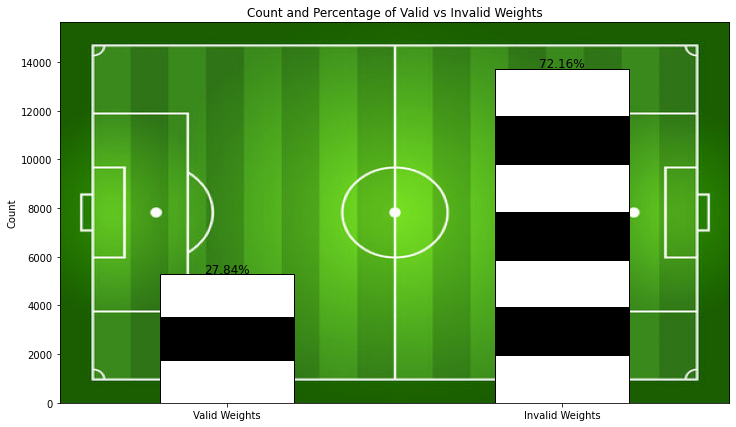

In [38]:
#evaluating weight
# Load the raw player ratings DataFrame (assuming it is loaded as raw_player_ratings_df)
# file_path = 'path_to_your/FUT_player_data.csv'
# raw_player_ratings_df = pd.read_csv(file_path)

# Define valid and invalid weights
valid_weights = raw_player_ratings_df[raw_player_ratings_df['weight'] > 0]['weight']
invalid_weights = raw_player_ratings_df[raw_player_ratings_df['weight'] <= 0]['weight']

# Count valid and invalid weights
valid_count = len(valid_weights)
invalid_count = len(invalid_weights)
total_count = valid_count + invalid_count

# Calculate the percentage of valid and invalid weights
valid_percentage = (valid_count / total_count) * 100
invalid_percentage = (invalid_count / total_count) * 100

# Load the soccer field image
image_path = '../data/img/image.png'  # Adjust the path to the location of your soccer field image
soccer_field_img = plt.imread(image_path)

# Define soccer ball-like colors (alternating black and white)
soccer_ball_colors = ['white', 'black']

# Adjust the positions of the bars towards the center of the field
adjusted_bar_positions = [0.5, 2.5]

# Initialize the figure
fig, ax = plt.subplots(figsize=(12, 7))

# Display the soccer field image as the background
ax.imshow(soccer_field_img, extent=[-0.5, 3.5, 0, max(valid_count, invalid_count) + (0.1 * total_count)], aspect='auto')

# Plot the bars with soccer ball-like colors at the adjusted positions
bars = ax.bar(adjusted_bar_positions, [valid_count, invalid_count], color=soccer_ball_colors)

# Add patterns to the bars to resemble soccer balls
for idx, bar in enumerate(bars):
    # Calculate the number of patches based on bar height
    num_patches = int(bar.get_height() // 2000) + 1
    patch_height = bar.get_height() / num_patches
    for i in range(num_patches):
        # Alternate between black and white patches
        color = soccer_ball_colors[i % 2]
        ax.add_patch(Rectangle((bar.get_x(), i * patch_height), bar.get_width(), patch_height, facecolor=color, edgecolor='black'))

# Set title and labels
ax.set_title('Count and Percentage of Valid vs Invalid Weights')
ax.set_ylabel('Count')
ax.set_xticks(adjusted_bar_positions)
ax.set_xticklabels(['Valid Weights', 'Invalid Weights'])

# Annotate the percentage above the bars
ax.text(adjusted_bar_positions[0], valid_count + (0.01 * total_count), f'{valid_percentage:.2f}%', ha='center', va='center', fontsize=12, color='black')
ax.text(adjusted_bar_positions[1], invalid_count + (0.01 * total_count), f'{invalid_percentage:.2f}%', ha='center', va='center', fontsize=12, color='black')

plt.show()


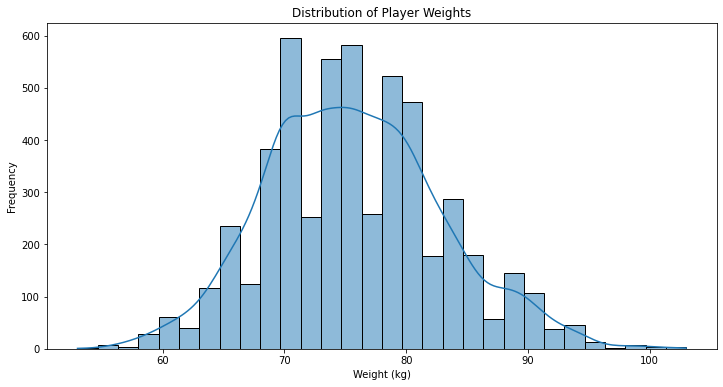

In [41]:
# Filter out invalid weights (0 or less)
valid_weights = raw_player_ratings_df[raw_player_ratings_df['weight'] > 0]['weight']

# Plot the distribution of valid weights
plt.figure(figsize=(12, 6))
sns.histplot(valid_weights, kde=True, bins=30)
plt.title('Distribution of Player Weights')
plt.xlabel('Weight (kg)')
plt.ylabel('Frequency')
plt.show()

# hide warnings
import warnings
warnings.filterwarnings('ignore')
# dont show FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)


## height

In [42]:
# Display rows with invalid height values
invalid_height_rows = raw_player_ratings_df[raw_player_ratings_df['height'] <= 0]
invalid_height_rows


,id,futbin_id,name,height,weight,age,club,league,nation,rarity,position,foot,attackWorkRate,defenseWorkRate,cardColor,overallRating,pace,shooting,passing,dribbling,defending,physicality,pace_acceleration,pace_sprintSpeed,shooting_positioning,shooting_finishing,shooting_shotPower,shooting_longShots,shooting_volleys,shooting_penalties,passing_vision,passing_crossing,passing_freeKickAccuracy,passing_shortPassing,passing_longPassing,passing_curve,dribbling_agility,dribbling_balance,dribbling_reactions,dribbling_ballControl,dribbling_dribbling,dribbling_composure,defending_interceptions,defending_headingAccuracy,defending_standingTackle,defending_slidingTackle,defending_defenseAwareness,phsyicality_jumping,physicality_stamina,physicality_strength,physicality_aggression,goalkeeper_diving,goalkeeper_handling,goalkeeper_kicking,goalkeeper_positioning,goalkeeper_reflexes,goalkeeper_speed
661,16913,50254,NaN,0,0,123,112658,2118,103,129,ST,Right,High,Low,gold,91,93,92,82,89,52,82,94.0,93.0,93.0,94.0,90.0,90.0,89.0,89.0,86.0,77.0,85.0,85.0,73.0,80.0,88.0,82.0,93.0,90.0,89.0,93.0,48.0,83.0,48.0,43.0,50.0,90.0,89.0,79.0,77.0,NaN,NaN,NaN,NaN,NaN,93
820,16908,50259,NaN,0,0,123,112658,2118,18,129,CB,Right,Med,High,gold,90,80,69,70,79,91,86,78.0,81.0,61.0,67.0,76.0,62.0,68.0,91.0,58.0,58.0,72.0,81.0,81.0,63.0,71.0,71.0,88.0,87.0,74.0,86.0,90.0,85.0,93.0,88.0,93.0,77.0,88.0,85.0,88.0,NaN,NaN,NaN,NaN,NaN,79
821,16910,50257,NaN,0,0,123,112658,2118,49,129,ST,Right,High,High,gold,90,86,91,73,86,35,75,85.0,87.0,93.0,92.0,91.0,88.0,87.0,86.0,76.0,62.0,89.0,76.0,66.0,89.0,83.0,82.0,87.0,85.0,88.0,84.0,37.0,85.0,29.0,25.0,26.0,86.0,77.0,78.0,61.0,NaN,NaN,NaN,NaN,NaN,86
822,16911,50256,NaN,0,0,123,112658,2118,54,129,LB,Left,High,High,gold,90,91,82,85,80,85,85,92.0,90.0,69.0,75.0,96.0,92.0,76.0,76.0,78.0,88.0,96.0,84.0,82.0,96.0,78.0,86.0,90.0,85.0,75.0,79.0,92.0,77.0,85.0,87.0,83.0,83.0,93.0,82.0,85.0,NaN,NaN,NaN,NaN,NaN,91
1265,16907,50260,NaN,0,0,123,112658,2118,83,129,ST,Right,High,Med,gold,88,92,88,73,88,48,69,94.0,91.0,90.0,91.0,86.0,83.0,83.0,88.0,73.0,68.0,81.0,75.0,71.0,75.0,93.0,85.0,88.0,87.0,87.0,86.0,35.0,93.0,47.0,52.0,41.0,88.0,81.0,64.0,61.0,NaN,NaN,NaN,NaN,NaN,92
3217,16597,49554,Kannemann,0,0,123,1369,0,52,128,CB,Left,Med,High,gold,78,72,39,47,59,79,85,71.0,72.0,38.0,27.0,76.0,31.0,33.0,37.0,43.0,32.0,38.0,58.0,56.0,34.0,64.0,75.0,78.0,55.0,54.0,80.0,78.0,77.0,79.0,78.0,79.0,84.0,83.0,85.0,88.0,NaN,NaN,NaN,NaN,NaN,71
3426,16762,50025,Anzai,0,0,123,1411,0,163,128,LB,Right,High,Med,gold,77,92,58,71,72,67,65,93.0,91.0,64.0,54.0,68.0,59.0,46.0,54.0,68.0,76.0,62.0,71.0,71.0,73.0,84.0,84.0,72.0,71.0,70.0,65.0,63.0,51.0,69.0,69.0,71.0,80.0,99.0,48.0,63.0,NaN,NaN,NaN,NaN,NaN,92
3427,16763,50024,Contreras,0,0,123,1383,0,72,128,ST,Right,Med,Low,gold,77,71,79,50,75,30,60,71.0,71.0,72.0,80.0,79.0,81.0,70.0,71.0,53.0,34.0,40.0,68.0,32.0,39.0,65.0,75.0,76.0,77.0,78.0,53.0,20.0,86.0,26.0,25.0,23.0,71.0,66.0,69.0,29.0,NaN,NaN,NaN,NaN,NaN,71
3440,16736,50051,Tchamba,0,0,123,1395,0,103,128,CB,Left,Med,Med,gold,77,81,44,54,63,75,84,84.0,79.0,45.0,40.0,50.0,45.0,39.0,50.0,47.0,46.0,35.0,61.0,67.0,43.0,61.0,71.0,57.0,67.0,61.0,63.0,75.0,76.0,77.0,73.0,73.0,91.0,78.0,92.0,70.0,NaN,NaN,NaN,NaN,NaN,81
3456,16752,50035,Ghareeb,0,0,123,111114,0,183,128,LM,Right,Med,Med,gold,77,92,68,66,80,32,62,94.0,90.0,73.0,69.0,73.0,66.0,53.0,66.0,68.0,67.0,49.0,68.0,65.0,65.0,96.0,98.0,68.0,75.0,81.0,68.0,26.0,59.0,29.0,22.0,32.0,69.0,81.0,62.0,37.0,NaN,NaN,NaN,NaN,NaN,92


41 rows where the 'height' value is invalid (0 or less). Additionally, in these rows, the 'weight' values are also invalid (0), and the 'age' values are unusually high (123), which are clear inconsistencies. Furthermore, several of these rows have missing player names (NaN in the 'name' column).

In [43]:
# Display rows with invalid age values
invalid_age_rows = raw_player_ratings_df[raw_player_ratings_df['age'] <= 0]
invalid_age_rows


,id,futbin_id,name,height,weight,age,club,league,nation,rarity,position,foot,attackWorkRate,defenseWorkRate,cardColor,overallRating,pace,shooting,passing,dribbling,defending,physicality,pace_acceleration,pace_sprintSpeed,shooting_positioning,shooting_finishing,shooting_shotPower,shooting_longShots,shooting_volleys,shooting_penalties,passing_vision,passing_crossing,passing_freeKickAccuracy,passing_shortPassing,passing_longPassing,passing_curve,dribbling_agility,dribbling_balance,dribbling_reactions,dribbling_ballControl,dribbling_dribbling,dribbling_composure,defending_interceptions,defending_headingAccuracy,defending_standingTackle,defending_slidingTackle,defending_defenseAwareness,phsyicality_jumping,physicality_stamina,physicality_strength,physicality_aggression,goalkeeper_diving,goalkeeper_handling,goalkeeper_kicking,goalkeeper_positioning,goalkeeper_reflexes,goalkeeper_speed
11496,1724,38373,Édouard Michut,0,0,0,106,14,18,0,CM,Right,High,Med,silver,66,62,53,65,71,57,49,65.0,59.0,61.0,50.0,58.0,55.0,48.0,55.0,67.0,59.0,48.0,70.0,66.0,61.0,72.0,78.0,65.0,71.0,71.0,70.0,62.0,45.0,61.0,56.0,55.0,40.0,57.0,42.0,60.0,NaN,NaN,NaN,NaN,NaN,62


### old age

In [47]:
# Display rows with unusually high age values (e.g., age greater than 100, which is unrealistic for football players)
unusually_high_age_rows = raw_player_ratings_df[raw_player_ratings_df['age'] > 50]
unusually_high_age_rows


,id,futbin_id,name,height,weight,age,club,league,nation,rarity,position,foot,attackWorkRate,defenseWorkRate,cardColor,overallRating,pace,shooting,passing,dribbling,defending,physicality,pace_acceleration,pace_sprintSpeed,shooting_positioning,shooting_finishing,shooting_shotPower,shooting_longShots,shooting_volleys,shooting_penalties,passing_vision,passing_crossing,passing_freeKickAccuracy,passing_shortPassing,passing_longPassing,passing_curve,dribbling_agility,dribbling_balance,dribbling_reactions,dribbling_ballControl,dribbling_dribbling,dribbling_composure,defending_interceptions,defending_headingAccuracy,defending_standingTackle,defending_slidingTackle,defending_defenseAwareness,phsyicality_jumping,physicality_stamina,physicality_strength,physicality_aggression,goalkeeper_diving,goalkeeper_handling,goalkeeper_kicking,goalkeeper_positioning,goalkeeper_reflexes,goalkeeper_speed
2,18982,54249,Zinedine Zidane,185,77,51,112658,2118,18,171,CAM,Right,Med,Med,gold,99,92,96,99,97,87,90,93.0,92.0,96.0,95.0,95.0,99.0,97.0,94.0,99.0,99.0,99.0,99.0,99.0,99.0,88.0,90.0,99.0,99.0,99.0,99.0,95.0,99.0,88.0,72.0,83.0,87.0,94.0,92.0,83.0,NaN,NaN,NaN,NaN,NaN,92
3,18730,54005,Pelé,173,70,82,112658,2118,54,153,LW,Right,High,Med,gold,99,96,97,94,99,61,78,96.0,96.0,98.0,99.0,95.0,95.0,96.0,94.0,98.0,91.0,90.0,97.0,89.0,90.0,97.0,96.0,99.0,99.0,99.0,99.0,68.0,96.0,54.0,50.0,56.0,90.0,91.0,78.0,61.0,NaN,NaN,NaN,NaN,NaN,96
7,19006,54292,Lothar Matthäus,174,70,62,112658,2118,21,171,CM,Right,High,High,gold,99,95,97,99,96,99,95,98.0,92.0,99.0,94.0,99.0,99.0,94.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,97.0,96.0,99.0,99.0,94.0,99.0,99.0,94.0,99.0,99.0,99.0,80.0,99.0,92.0,99.0,NaN,NaN,NaN,NaN,NaN,95
22,14112,62,Pelé,173,70,82,112658,2118,54,12,CAM,Right,High,Med,gold,98,95,96,93,96,60,76,95.0,95.0,97.0,98.0,94.0,94.0,95.0,93.0,97.0,90.0,89.0,96.0,88.0,89.0,94.0,93.0,98.0,97.0,96.0,98.0,67.0,94.0,53.0,49.0,55.0,88.0,86.0,76.0,59.0,NaN,NaN,NaN,NaN,NaN,95
25,18994,54284,Abedi Pelé,174,67,58,114605,16,117,154,CAM,Left,High,Med,gold,98,99,93,96,98,57,82,99.0,99.0,93.0,90.0,93.0,96.0,95.0,96.0,99.0,98.0,92.0,97.0,86.0,97.0,99.0,97.0,98.0,99.0,98.0,88.0,51.0,94.0,52.0,49.0,56.0,93.0,99.0,81.0,58.0,NaN,NaN,NaN,NaN,NaN,99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14673,14525,37506,Ovelar,170,0,123,112716,1003,58,53,RM,Left,Med,Med,bronze,62,71,58,58,64,48,50,74.0,69.0,62.0,55.0,65.0,57.0,55.0,61.0,65.0,58.0,45.0,60.0,48.0,53.0,67.0,63.0,55.0,62.0,65.0,62.0,45.0,45.0,55.0,45.0,45.0,32.0,51.0,58.0,35.0,NaN,NaN,NaN,NaN,NaN,71
14779,12281,36939,Gutiérrez,173,0,123,111325,1003,60,53,CF,Right,Med,Med,bronze,62,71,61,62,63,40,49,66.0,75.0,50.0,59.0,72.0,60.0,56.0,50.0,66.0,49.0,51.0,68.0,65.0,55.0,53.0,67.0,59.0,67.0,62.0,65.0,26.0,50.0,46.0,51.0,37.0,60.0,34.0,56.0,46.0,NaN,NaN,NaN,NaN,NaN,70
15466,14433,36492,Romero,176,0,123,112670,1003,52,0,ST,Right,High,Med,bronze,61,59,65,44,62,21,48,62.0,57.0,65.0,68.0,61.0,64.0,53.0,67.0,47.0,38.0,43.0,47.0,39.0,49.0,66.0,60.0,63.0,60.0,62.0,64.0,17.0,55.0,15.0,22.0,18.0,62.0,55.0,44.0,47.0,NaN,NaN,NaN,NaN,NaN,59
15636,10457,35112,Cechi,179,0,123,110395,1014,52,52,CM,Right,Med,Med,bronze,61,63,56,59,66,53,58,65.0,62.0,44.0,53.0,63.0,63.0,41.0,47.0,59.0,47.0,45.0,67.0,63.0,47.0,74.0,73.0,65.0,66.0,64.0,67.0,45.0,55.0,56.0,58.0,53.0,59.0,53.0,60.0,61.0,NaN,NaN,NaN,NaN,NaN,63


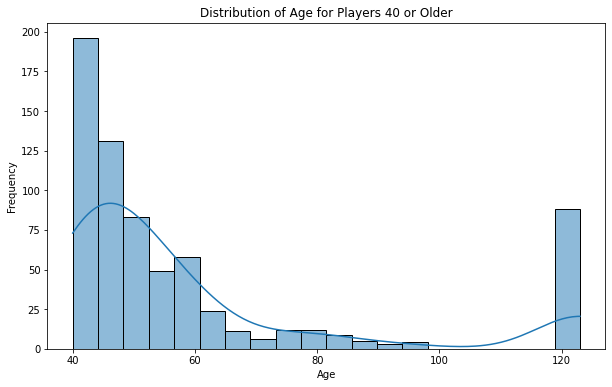

In [48]:
# Plot the distribution of age for players aged 40 or older
plt.figure(figsize=(10,6))
sns.histplot(raw_player_ratings_df[raw_player_ratings_df['age'] >= 40]['age'], bins=20, kde=True)
plt.title('Distribution of Age for Players 40 or Older')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


# transfer_fees

In [51]:
preprocessed_transfer_fees

,club,name,age,nationality,position,short_pos,market_value,dealing_club,dealing_country,fee,movement,window,league,season,is_loan,loan_status,Year,age_group
0,Arsenal Fc,John Jensen,27.0,Denmark,Central Midfield,CM,0.0,Bröndby If,Denmark,1600000.0,in,summer,Premier League,1992,False,Not Applicable,1992,25-30
1,Arsenal Fc,David Rocastle,25.0,England,Attacking Midfield,AM,0.0,Leeds,England,2400000.0,out,summer,Premier League,1992,False,Not Applicable,1992,20-25
2,Arsenal Fc,Perry Groves,27.0,England,Left Winger,LW,0.0,Southampton,England,850000.0,out,summer,Premier League,1992,False,Not Applicable,1992,25-30
3,Arsenal Fc,Gary Mckeown,21.0,England,Midfield,MIDFIELD,0.0,Dundee Fc,Scotland,0.0,out,summer,Premier League,1992,False,Not Applicable,1992,20-25
4,Arsenal Fc,Ty Gooden,19.0,England,Midfield,MIDFIELD,0.0,Wycombe,England,0.0,out,summer,Premier League,1992,False,Not Applicable,1992,<20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77091,Stade Rennais Fc,Jérémy Gélin,23.0,France,Centre-Back,CB,4800000.0,Royal Antwerp,Belgium,0.0,out,summer,Ligue 1,2020,True,free loan,2020,20-25
77092,Stade Rennais Fc,Riffi Mandanda,27.0,Dr Congo,Goalkeeper,GK,325000.0,Without Club,Unknown,0.0,out,summer,Ligue 1,2020,False,Not Applicable,2020,25-30
77093,Stade Rennais Fc,Joris Gnagnon,23.0,France,Centre-Back,CB,4800000.0,Sevilla Fc,Spain,0.0,out,summer,Ligue 1,2020,True,end of loan,2020,20-25
77094,Stade Rennais Fc,M'Baye Niang,26.0,Senegal,Centre-Forward,CF,10000000.0,Ahli,Saudi Arabia,1500000.0,out,winter,Ligue 1,2020,True,loan with fee,2020,25-30


# transfer fee > $0

In [56]:
## transfer fees 
# # Calculate the number of zero and non-zero transfer fees
num_zero_fees = (preprocessed_transfer_fees['fee'] == 0).sum()
num_non_zero_fees = (preprocessed_transfer_fees['fee'] > 0).sum()

# Calculate percentages
percent_zero = (num_zero_fees / (num_zero_fees + num_non_zero_fees)) * 100
percent_non_zero = (num_non_zero_fees / (num_zero_fees + num_non_zero_fees)) * 100

# Display the proportions as percentages
# percent_zero, percent_non_zero



# Print the results with text information
print("Number of Zero Transfer Fees:", num_zero_fees, ", Proportion of Zero Transfer Fees: {:.1f}%".format(percent_zero))
print("Number of Non-Zero Transfer Fees:", num_non_zero_fees, ", Proportion of Non-Zero Transfer Fees: {:.1f}%".format(percent_non_zero))


Number of Zero Transfer Fees: 55316 , Proportion of Zero Transfer Fees: 71.7%
Number of Non-Zero Transfer Fees: 21780 , Proportion of Non-Zero Transfer Fees: 28.3%


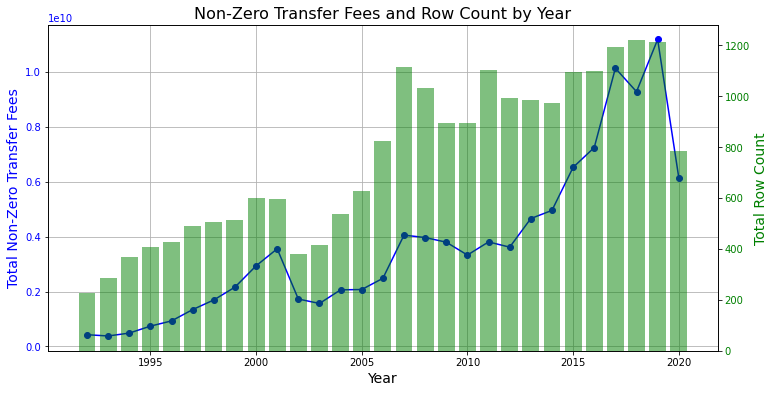

In [59]:
import matplotlib.pyplot as plt

# Filter the dataset to include only non-zero transfer fees
non_zero_transfer_fees_df = preprocessed_transfer_fees[preprocessed_transfer_fees['fee'] > 0]

# Group the data by year and calculate the total non-zero transfer fees and count of rows for each year
yearly_non_zero_fees = non_zero_transfer_fees_df.groupby('Year')['fee'].sum()
yearly_row_counts = non_zero_transfer_fees_df.groupby('Year').size()

# Create a figure with two subplots
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot total non-zero transfer fees (line plot on the first subplot)
ax1.set_xlabel('Year', fontsize=14)
ax1.set_ylabel('Total Non-Zero Transfer Fees', color='b', fontsize=14)
ax1.plot(yearly_non_zero_fees.index, yearly_non_zero_fees.values, marker='o', linestyle='-', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True)

# Create a second subplot sharing the same x-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Total Row Count', color='g', fontsize=14)
ax2.bar(yearly_row_counts.index, yearly_row_counts.values, color='g', alpha=0.5)
ax2.tick_params(axis='y', labelcolor='g')

# Set titles and legends
plt.title('Non-Zero Transfer Fees and Row Count by Year', fontsize=16)
plt.xlabel('Year', fontsize=14)

# Show the combined graph
plt.show()


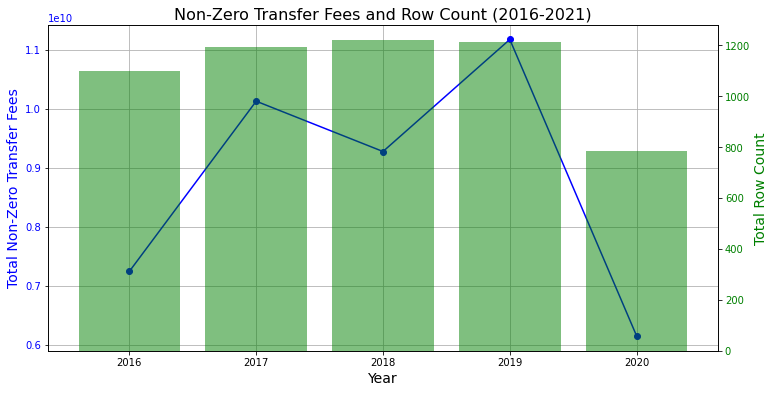

In [63]:
# Filter the dataset to include only the years 2016 to 2021
years_of_interest = range(2016, 2022)
filtered_df = preprocessed_transfer_fees[
    (preprocessed_transfer_fees['Year'] >= 2016) & (preprocessed_transfer_fees['Year'] <= 2021)
]

# Filter the dataset to include only non-zero transfer fees within the specified years
non_zero_transfer_fees_df = filtered_df[filtered_df['fee'] > 0]

# Group the data by year and calculate the total non-zero transfer fees and count of rows for each year
yearly_non_zero_fees = non_zero_transfer_fees_df.groupby('Year')['fee'].sum()
yearly_row_counts = non_zero_transfer_fees_df.groupby('Year').size()

# Create a figure with two subplots
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot total non-zero transfer fees (line plot on the first subplot)
ax1.set_xlabel('Year', fontsize=14)
ax1.set_ylabel('Total Non-Zero Transfer Fees', color='b', fontsize=14)
ax1.plot(yearly_non_zero_fees.index, yearly_non_zero_fees.values, marker='o', linestyle='-', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True)

# Create a second subplot sharing the same x-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Total Row Count', color='g', fontsize=14)
ax2.bar(yearly_row_counts.index, yearly_row_counts.values, color='g', alpha=0.5)
ax2.tick_params(axis='y', labelcolor='g')

# Set titles and legends
plt.title('Non-Zero Transfer Fees and Row Count (2016-2021)', fontsize=16)
plt.xlabel('Year', fontsize=14)

# Show the combined graph
plt.show()


## Year

In [64]:
# Find the maximum year in the dataset
max_year = preprocessed_transfer_fees['Year'].max()

# Display the maximum year
max_year


2020

#### can we identify the actual cutoff data or is through the end of 2020? otherwise 2020 looks truncated

## Names

In [67]:
# Check for duplicate names in the dataset
duplicate_names = preprocessed_transfer_fees[preprocessed_transfer_fees.duplicated(subset='name', keep=False)]

# Display the duplicate names, if any
len(duplicate_names['name'].unique())


14972